In [ ]:
#####Reference: https://medium.com/mlearning-ai/image-classification-for-beginner-a6de7a69bc78

from __future__ import absolute_import, division, print_function
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split # importing python libraries

from google.colab import drive


In [ ]:
# setting the file path and impoting data
drive.mount('/content/drive')
img_path = "/content/drive/My Drive/GrenwaveSentcorpProject/FishClassifierData/"
# labels for the data and reading of data
fish_label  = ['Healthy','Infected']
img_list = []
label_list = []
for label in fish_label:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)

df = pd.DataFrame({'img':img_list, 'label':label_list})
df.head(4)

MessageError: ignored

In [ ]:
n

In [ ]:
#data details
df['label'].value_counts()

Healthy     25
Infected     6
Name: label, dtype: int64

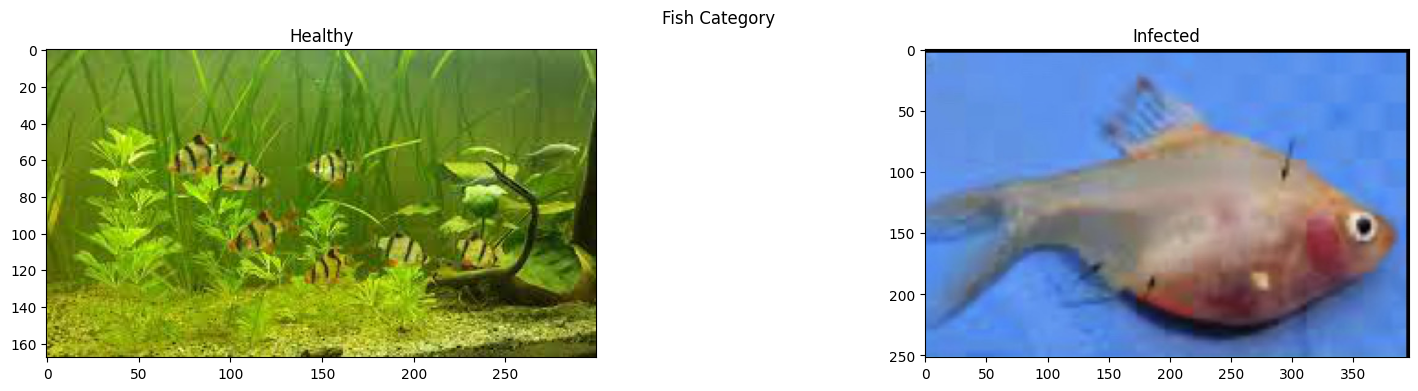

In [ ]:
# inspect data
fig, ax = plt.subplots(ncols=len(fish_label), figsize=(20,4))
fig.suptitle('Fish Category')
random_num = 1
for i,label in enumerate(fish_label):
    ax[i].set_title(label)
    ax[i].imshow(plt.imread(df[df['label']==label]['img'].iloc[random_num]))

In [ ]:
# reads image shape
plt.imread(df['img'][0]).shape

(202, 250, 3)

In [ ]:
# Create a dataframe for mapping label
df_labels = {
    'Healthy':0 ,
    'Infected':1
}
# Encode
df['encode_label'] = df['label'].map(df_labels)
df.head()

,img,label,encode_label
0,/content/drive/My Drive/GrenwaveSentcorpProjec...,Healthy,0
1,/content/drive/My Drive/GrenwaveSentcorpProjec...,Healthy,0
2,/content/drive/My Drive/GrenwaveSentcorpProjec...,Healthy,0
3,/content/drive/My Drive/GrenwaveSentcorpProjec...,Healthy,0
4,/content/drive/My Drive/GrenwaveSentcorpProjec...,Healthy,0


In [ ]:
#Data augmentation with tf.data and TensorFlow
# import the necessary packages
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import Sequential
# data augmentation by rotation
data_augmentation1 = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
# data augmentation by rotation with a different angle
data_augmentation2 = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])
# data augmentation by zooming
data_augmentation3 =  keras.Sequential([
	preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	preprocessing.RandomRotation(0.3)
])

In [ ]:
# reformating data to bring it to the required input format

X = []
y = []
for i in range(len(df)):
    img = df['img'].iloc[i]
    img = cv2.imread(str(img))

    img = cv2.resize(img, (96, 96))
    img = img/255
    X.append(img)
    y.append(df['encode_label'].iloc[i])
    img_aug = data_augmentation1(img)
    X.append(img_aug)
    y.append(df['encode_label'].iloc[i])
    img_aug = data_augmentation2(img)
    X.append(img_aug)
    y.append(df['encode_label'].iloc[i])
    img_aug = data_augmentation3(img)
    X.append(img_aug)
    y.append(df['encode_label'].iloc[i])


In [ ]:
# number of datapoints after data augmentation
len(X)

124

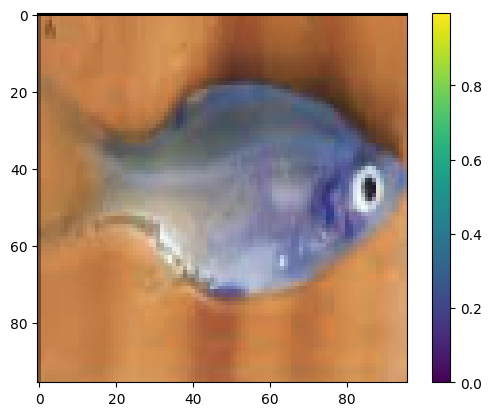

In [ ]:
# inspecting the augmented data
plt.figure()
plt.imshow(X[100])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
# Train/Validation/Test split
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [ ]:
# reformating data to bring it to the required input format
X_train = tf.stack(X_train)
y_train = tf.stack(y_train)
X_val = tf.stack(X_val)
y_val = tf.stack(y_val)
X_test = tf.stack(X_test)
y_test = tf.stack(y_test)
X= tf.stack(X)

In [ ]:
#Using VGG16 as a base model
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=(96,96,3), include_top=False, weights='imagenet')

base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

In [ ]:
 #freezing the VGG16 model parameters and allow to adjust only parameters in the last layer to reduce computation workload.
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [ ]:
# Adding layers to the model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
model = Sequential()
model.add(Input(shape=(96,96,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(fish_label), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 15,895,106
Trainable params: 8,259,842
N

In [ ]:
# Training the model
model.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])
history = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=5
)

Epoch 1/5
3/3 [==============================] - 16s 5s/step - loss: 3.6034 - acc: 0.7419 - val_loss: 0.6234 - val_acc: 0.6250
Epoch 2/5
3/3 [==============================] - 15s 5s/step - loss: 0.7089 - acc: 0.8387 - val_loss: 0.5272 - val_acc: 0.6250
Epoch 3/5
3/3 [==============================] - 14s 5s/step - loss: 0.6724 - acc: 0.7204 - val_loss: 3.0184 - val_acc: 0.6250
Epoch 4/5
3/3 [==============================] - 13s 5s/step - loss: 0.6229 - acc: 0.8495 - val_loss: 0.6125 - val_acc: 0.6250
Epoch 5/5
3/3 [==============================] - 12s 4s/step - loss: 0.3180 - acc: 0.8710 - val_loss: 0.3505 - val_acc: 0.8750


In [ ]:
# Model evaluation
model.evaluate(X_test,y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.2667 - acc: 0.9565


[0.26672276854515076, 0.95652174949646]

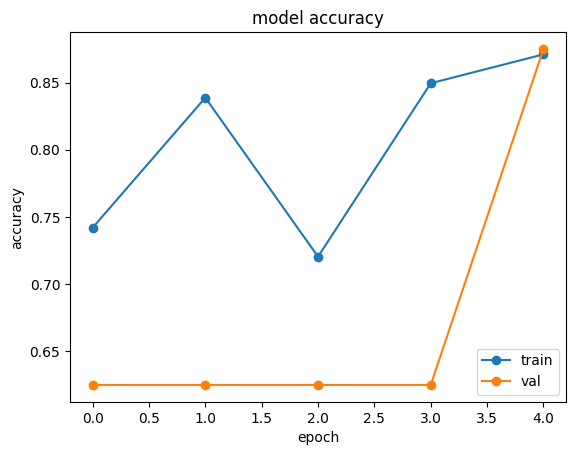

In [ ]:
# showing model accuracy
plt.plot(history.history['acc'], marker='o')
plt.plot(history.history['val_acc'], marker='o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

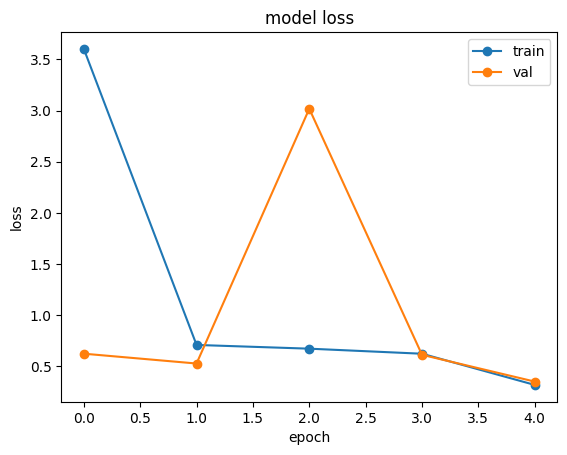

In [ ]:
# showing model loss
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# perdiction
predictions = model.predict(X)
predictions[0]

4/4 [==============================] - 13s 3s/step


array([0.85499465, 0.14500539], dtype=float32)

In [ ]:
# perdiction
predictions = model.predict(X)
predictions[25]

4/4 [==============================] - 13s 3s/step


array([0.7410469 , 0.25895312], dtype=float32)

In [ ]:
# perdiction
predictions = model.predict(X)
predictions[101]

4/4 [==============================] - 13s 3s/step


array([0.3861316, 0.6138683], dtype=float32)

In [ ]:
#####################################
#### Prediction for the new images###
#####################################

In [ ]:
###### Read and predict the class for a new image
img_path = "/content/drive/My Drive/GrenwaveSentcorpProject/FishClassifierData/NewImages/"
# labels for the data and reading of data

img_list = []

for img_file in os.listdir(img_path):
    img_list.append(img_path+'/'+img_file)

df_pred = pd.DataFrame({'img':img_list})
df_pred

,img
0,/content/drive/My Drive/GrenwaveSentcorpProjec...
1,/content/drive/My Drive/GrenwaveSentcorpProjec...
2,/content/drive/My Drive/GrenwaveSentcorpProjec...
3,/content/drive/My Drive/GrenwaveSentcorpProjec...
4,/content/drive/My Drive/GrenwaveSentcorpProjec...
5,/content/drive/My Drive/GrenwaveSentcorpProjec...
6,/content/drive/My Drive/GrenwaveSentcorpProjec...
7,/content/drive/My Drive/GrenwaveSentcorpProjec...
8,/content/drive/My Drive/GrenwaveSentcorpProjec...
9,/content/drive/My Drive/GrenwaveSentcorpProjec...


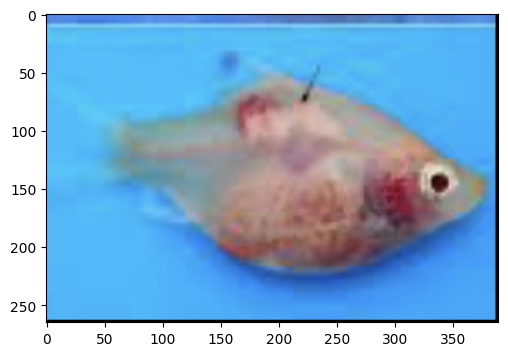

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
random_num = 5
ax.imshow(plt.imread(df_pred['img'].iloc[random_num]))

In [ ]:
X = []

for i in range(len(df_pred)):
    img = df_pred['img'].iloc[i]
    img = cv2.imread(str(img))

    img = cv2.resize(img, (96, 96))
    img = img/255
    X.append(img)

X= tf.stack(X)

predictions = model.predict(X)

1/1 [==============================] - 3s 3s/step


###############################
PREDICTION RESULT: Infected fish found!
###############################
Inspect the follwong fish:


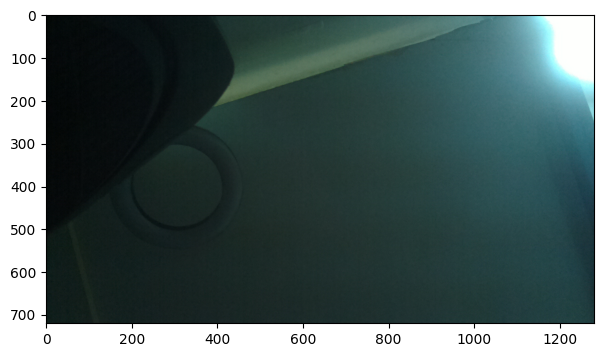

In [ ]:

result_class_list = []
index_infected = []
for i in range(len(X)):
  pred_prob_arr = predictions[i]
  if pred_prob_arr[0] > 0.5:
    result_class_list.append(0)
  else:
    result_class_list.append(1)
    index_infected.append(i)

if len(index_infected) ==0:
  print("###############################")
  print("PREDICTION RESULT: All healthy!")
  print("###############################")
else:
  print("###############################")
  print("PREDICTION RESULT: Infected fish found!")
  print("###############################")
  print("Inspect the follwong fish:")
  fig, ax = plt.subplots(figsize=(20,4))
  for i in index_infected:
    ax.imshow(plt.imread(df_pred['img'].iloc[i]))


